# p.123 연습
대출자들의 채무 상환과 관련된 데이터를 활용하여 상환 여부를 예측하기 위한 XGBoost 분석을 실시하고 결과를 해석하시오.
* 목표변수 : BAD(범주형)
* 데이터 비율 train : test = 0.7 : 0.3
* random_state = 1234

# Step 0. 패키지 불러오기

### XGBoost 패키지 설치

In [1]:
# !pip install xgboost

### 패키지 불러오기

In [23]:
# 데이터 구성
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# 한글, 음수 표시
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
# 데이터 분리
from sklearn.model_selection import train_test_split
# XGBoostClassifier
from xgboost import XGBClassifier as XBC
# 변수 중요도
from xgboost import plot_importance
# 평가함수
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report
# 경고 메시지
import warnings
warnings.filterwarnings('ignore')

### 분류모델 평가 : 혼동행렬, 정확도, 정밀도, 재현율, F1-score, AUC

In [20]:
def eval_class_model(y_test, y_pred) :
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('Confusion Matrix : \n{}',confusion,'\n')
    print('Accuracy : {:.4f}'.format(accuracy))
    print('Precision : {:.4f}'.format(precision))
    print('Recall : {:.4f}'.format(recall))
    print('F1-score : {:.4f}'.format(F1))
    print('AUC : {:.4f}'.format(AUC))

# Step 1. 데이터 구성하기

### 데이터 불러오기

In [4]:
df_raw = pd.read_csv('D:/Study/PoscoAcademy/2_bigdata/raw_data/HMEQ.csv')
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


### 결측치 확인

In [5]:
# 결측치 확인
df_raw.isna().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [6]:
# JOB 변수 결측치 Other 대체
df_raw['JOB'].fillna('Other', inplace = True)
# 숫자형 변수 결측치 평균 대체
df_raw.fillna(df_raw.mean(), inplace = True)

### 더미변수 생성

In [7]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


### 데이터 분리

In [8]:
# 설명변수, 목표변수 데이터 구분
df_raw_x = df_raw_dummy.drop('BAD', axis = 1, inplace = False)
df_raw_y = df_raw_dummy['BAD']
# 데이터 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234)
print('train data X size :', df_train_x.shape)
print('train data Y size :', df_train_y.shape)
print('test data X size :', df_test_x.shape)
print('test data Y size :', df_test_y.shape)

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


# Step 2. XGBoost 모델 생성

### 기본 옵션으로 모델 생성

In [9]:
# 기본 모델
xbc_basic = XBC(random_state = 1234)
xbc_basic.fit(df_train_x, df_train_y)
# train/test 데이터 설명력
print('Score in train set :', xbc_basic.score(df_train_x, df_train_y).round(4))
print('Score in test set :', xbc_basic.score(df_test_x, df_test_y).round(4))

Score in train set : 1.0
Score in test set : 0.9467


### Hyper Parameter

In [14]:
# 사용자 모델
xbc = XBC(learning_rate = 0.1,
          n_estimators = 100,
          max_depth = 5)
xbc.fit(df_train_x, df_train_y)
# train/test 데이터 설명력
print('Score in train set :', xbc.score(df_train_x, df_train_y).round(4))
print('Score in test set :', xbc.score(df_test_x, df_test_y).round(4))

Score in train set : 0.9813
Score in test set : 0.9431


### Early_stopping

In [21]:
xbc_es = XBC(learning_rate = 0.1,
             n_estimators = 300,
             max_depth = 6)
eval_df = [(df_test_x, df_test_y)]
xbc_es.fit(df_train_x, df_train_y,
           early_stopping_rounds = 150,
           eval_metric = 'logloss',
           eval_set = eval_df,
           verbose = True)

[0]	validation_0-logloss:0.62092
[1]	validation_0-logloss:0.56184
[2]	validation_0-logloss:0.51341
[3]	validation_0-logloss:0.47230
[4]	validation_0-logloss:0.43716
[5]	validation_0-logloss:0.40648
[6]	validation_0-logloss:0.38075
[7]	validation_0-logloss:0.35740
[8]	validation_0-logloss:0.33736
[9]	validation_0-logloss:0.32025
[10]	validation_0-logloss:0.30528
[11]	validation_0-logloss:0.29236
[12]	validation_0-logloss:0.28106
[13]	validation_0-logloss:0.27113
[14]	validation_0-logloss:0.26233
[15]	validation_0-logloss:0.25407
[16]	validation_0-logloss:0.24520
[17]	validation_0-logloss:0.23947
[18]	validation_0-logloss:0.23388
[19]	validation_0-logloss:0.22930
[20]	validation_0-logloss:0.22485
[21]	validation_0-logloss:0.22028
[22]	validation_0-logloss:0.21723
[23]	validation_0-logloss:0.21451
[24]	validation_0-logloss:0.21211
[25]	validation_0-logloss:0.20965
[26]	validation_0-logloss:0.20786
[27]	validation_0-logloss:0.20589
[28]	validation_0-logloss:0.20396
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [24]:
# 모델 평가
xbc_pred_es = xbc_es.predict(df_test_x)
print('\n조기 중단 모델 평가 : Test\n')
eval_class_model(df_test_y, xbc_pred_es)
print('\n',classification_report(df_test_y, xbc_pred_es))


조기 중단 모델 평가 : Test

Confusion Matrix : 
{} [[1020    1]
 [  62   42]] 

Accuracy : 0.9440
Precision : 0.9767
Recall : 0.4038
F1-score : 0.5714
AUC : 0.7014

               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1021
           1       0.98      0.40      0.57       104

    accuracy                           0.94      1125
   macro avg       0.96      0.70      0.77      1125
weighted avg       0.95      0.94      0.93      1125



# Step 3. 결론 도출

### 설명변수 중요도 그래프

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

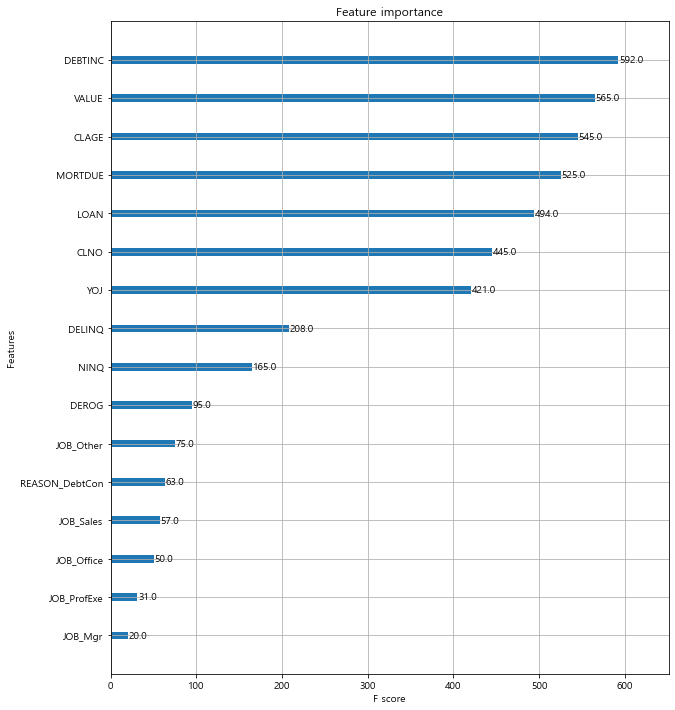

In [25]:
fig, ax = plt.subplots(figsize = (10,12))
plot_importance(xbc_es, ax = ax)

* DEBTINC, VALUE, CLAGE 순으로 영향이 크다고 볼 수 있다.
* 선택되는 데이터에 따라 중요도가 변경될 수 있다.